# Clustering tweets about Machine Learning using self-organizing maps

*Arnaud Le Doeuff*
*Ignacio Dorado*
*11/20*

## Usefull Links

- https://github.com/RodolfoFerro/pandas_twitter/blob/master/01-extracting-data.md
- https://github.com/sevamoo/SOMPY

## Module importation

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import sompy3
import tweepy
import csv
import re

from tensorflow.keras.preprocessing import text
from sklearn.decomposition import PCA

## 1. Capture the tweets

Talk about twitter api, credentials and stafff...

In [2]:
from credentials import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    return api

# We create an extractor object:
extractor = twitter_setup()

Twitter will only allow us to download 3200 tweets every 15 minutes, which is not a lot considering most of them are retweeets. Only 7 days (or so) can be retrieved

In [3]:
# Words we want to search for
searchQuery = "machine learning"

# Maximum number of tweets we want to collect 
maxTweets = 10000

# Show our current limitations
extractor.rate_limit_status()['resources']['search']

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1605742854}}

In [5]:
tweetCount = 0
global_count = 0
# We create a tweet list as follows:
tweets=[]
#Tell the Cursor method that we want to use the Search API (api.search)
#Also tell Cursor our query, and the maximum number of tweets to return
for tweet in tweepy.Cursor(extractor.search,q=searchQuery, tweet_mode='extended').items(maxTweets):
    
    #Verify the tweet has place info before writing (It should, if it got past our place filter)
    if not tweet.full_text.startswith("RT "):
            tweets.append(tweet)
            tweetCount += 1
    global_count += 1 
    
    if (global_count%1000 == 0):
        print("Downloaded {0} tweets".format(global_count))
        print("Kept {0} non RT tweets".format(tweetCount))
        print("---------------------------")
    

#Display how many tweets we have collected
print("Downloaded {0} tweets".format(global_count))
print("Kept {0} non RT tweets".format(tweetCount))

Downloaded 1000 tweets
Kept 238 non RT tweets
---------------------------
Downloaded 2000 tweets
Kept 450 non RT tweets
---------------------------


Rate limit reached. Sleeping for: 794


Downloaded 3000 tweets
Kept 638 non RT tweets
---------------------------
Downloaded 4000 tweets
Kept 882 non RT tweets
---------------------------
Downloaded 5000 tweets
Kept 1102 non RT tweets
---------------------------


Rate limit reached. Sleeping for: 804


Downloaded 6000 tweets
Kept 1307 non RT tweets
---------------------------
Downloaded 7000 tweets
Kept 1578 non RT tweets
---------------------------


Rate limit reached. Sleeping for: 789


Downloaded 8000 tweets
Kept 1827 non RT tweets
---------------------------
Downloaded 9000 tweets
Kept 2081 non RT tweets
---------------------------
Downloaded 10000 tweets
Kept 2302 non RT tweets
---------------------------
Downloaded 10000 tweets
Kept 2302 non RT tweets


In [6]:
print ("Type of tweets: " + str(type(tweets)))
print ("Type of each tweet: " + str(type(tweets[0])))

Type of tweets: <class 'list'>
Type of each tweet: <class 'tweepy.models.Status'>


In [7]:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'display_text_range', 'entities', 'extended_entities', 'favorite', 'favorite_count', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'truncated', 'user']


### Creating a pandas DataFrame

In [8]:
# We create a pandas dataframe as follows:
df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])

#We add all the information we want to keep about the tweets
df['len']  = np.array([len(tweet.full_text) for tweet in tweets])
df['ID']   = np.array([tweet.id for tweet in tweets])
df['Date'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
df['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

# We display the first 10 elements of the dataframe:
pd.set_option('display.max_colwidth', 60)
display(df.head(100))

,Tweets,len,ID,Date,Source,Likes,RTs
0,SICK’s Deep Learning brings simplicity to complex AI ins...,303,1329334610946260992,2020-11-19 08:04:03,dlvr.it,0,0
1,Google Cloud Debuts Professional Machine Learning Engine...,103,1329334598455734277,2020-11-19 08:04:00,Paper.li,0,0
2,Bringing your own custom container image to Amazon SageM...,142,1329334594085269506,2020-11-19 08:03:59,HubSpot,0,0
3,Here’s what machines need to understand in order to trul...,238,1329334592449507331,2020-11-19 08:03:59,HubSpot,0,0
4,Level up your data science vocabulary: Geometric Distrib...,121,1329334535532670977,2020-11-19 08:03:45,DeepAI,0,0
...,...,...,...,...,...,...,...
95,5 Most Useful Machine Learning Tools every lazy full-sta...,124,1329322590670893059,2020-11-19 07:16:17,Paper.li,2,1
96,The way we train AI is fundamentally flawed https://t.co...,67,1329322554541154306,2020-11-19 07:16:09,Twitter for Android,3,1
97,Machine Learning: MLflow 1.12 verbessert die PyTorch-Int...,100,1329322407811801088,2020-11-19 07:15:34,Paper.li,0,0
98,"Your fleet is in safe hands with #JupiCar, an innovative...",296,1329322279893950464,2020-11-19 07:15:03,Twitter Web App,0,2


Now we save the Data Frame it to a csv file so we can read it every time

In [9]:
df.to_csv('tweets.csv', index=False)

In [2]:
df = pd.read_csv("tweets(2302).csv")

## 2. Preprocessing

- First thing would be to get rid off every comma, point and any other strange symbol
    - Discuss if @s should be removed or kept
    - Discuss if  hastags should be removed
    - Remove symbols that stands on their own
    - Remove urls
- Second thing would be creating the dictionary
- Then reducing the dictionay

### 2.1 Cleaning the strings

In [3]:
def clean_str(string):
    """
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"@[^\s]+", " ", string)             #remove account tags   
    string = re.sub(r"http[^\s]+", " ", string)          #remove urls
    string = re.sub(r"#[^\s]+", " ", string)             #remove hastags
    string = re.sub(r"[^A-Za-z\']", " ", string)         #remove everything but letters and nummbers(?)
    string = re.sub(r"\'s", " is", string)               #split 's contractions
    string = re.sub(r"\'ve", " have", string)            #split 's contractions
    string = re.sub(r"n\'t", " not", string)             #split n't contractions
    string = re.sub(r"\'re", " are", string)             #split 're contractions
    string = re.sub(r"\'d", " would", string)            #split 'd contractions
    string = re.sub(r"\'ll", " will", string)            #split 'll contractions
    string = re.sub(r"\'", " ", string)                  #remove '
    string = re.sub(r"!", " ! ", string)                 #split !
    string = re.sub(r"\?", " \? ", string)               #split ?
    string = re.sub(r"\s{2,}", " ", string)              #remove more than 1 white space
    return string.strip().lower()            #remove start and end white spaces

In [4]:
df['Tweets'] = df['Tweets'].apply(clean_str)

pd.set_option('display.max_colwidth', None)
df.head(3)

,Tweets,len,ID,Date,Source,Likes,RTs
0,sick s deep learning brings simplicity to complex ai inspection sick has launched a suite of deep learning apps and services to simplify machine vision quality inspection for challenging food products and agricultural produce especially those that have,303,1329334610946260992,2020-11-19 08:04:03,dlvr.it,0,0
1,google cloud debuts professional machine learning engineer certification,103,1329334598455734277,2020-11-19 08:04:00,Paper.li,0,0
2,bringing your own custom container image to amazon sagemaker studio notebooks,142,1329334594085269506,2020-11-19 08:03:59,HubSpot,0,0


### 2.2 Creating the dictionary

Justify why we did it in count mode and not in binary mode

In [5]:
train_tweets = df['Tweets'].values.tolist()

# Create a tokenizer for the nb_words most common words
tokenizer = text.Tokenizer()

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_tweets)

# Get the dictionaries
word_index = tokenizer.word_index     #dictionary word indexes (ordered by frequency)
word_count = tokenizer.word_counts    #dictionary word ocurrences

In [7]:
print("There are " + str(len(word_index)) + " unique tokens.\n")

print("Show the most frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=True)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 10: 
        break

print("\nShow the least frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=False)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 10: 
        break

There are 7396 unique tokens.

Show the most frequent word index:
   learning (1992) --> 1
   machine (1891) --> 2
   the (1273) --> 3
   to (1242) --> 4
   and (1181) --> 5
   a (857) --> 6
   of (756) --> 7
   is (737) --> 8
   in (728) --> 9
   for (595) --> 10
   with (402) --> 11

Show the least frequent word index:
   simplicity (1) --> 3240
   simplify (1) --> 3241
   container (1) --> 3242
   geometric (1) --> 3243
   flexes (1) --> 3244
   muscles (1) --> 3245
   wasn (1) --> 3246
   xataka (1) --> 3247
   xico (1) --> 3248
   academics (1) --> 3249
   ethics (1) --> 3250


### 2.3 Creating and reducing the vectorize representation

We have 7396 unique words in our dictionary, now we have to decide where to prune the dictionary
- Probably we need to remove the **most frequent** articles
    - I'll take away the 30 most frequent words (provisional)
- We will also remove the **least frequent** words by keeping only the 1000 most frequent words
    - We could think about increasing this number to get a better perfromance

In [8]:
# We will only get the 1000 most frequent words
tokenizer.num_words = 1000

# Vectorize texts into one-hot enconding representations
train_vectors = tokenizer.texts_to_matrix(train_tweets, mode='count')

print('First tweet: ' + train_tweets[0])
print('\nVector representation of the first tweet:\n' + str(train_vectors[0]))
print('\nShape of the training set (nb_examples, vector_size): ' + str(train_vectors.shape))

First tweet: sick s deep learning brings simplicity to complex ai inspection sick has launched a suite of deep learning apps and services to simplify machine vision quality inspection for challenging food products and agricultural produce especially those that have

Vector representation of the first tweet:
[0. 2. 1. 0. 2. 2. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [14]:
nb_words_to_remove = 30
train_vectors_reduced = np.delete(train_vectors, range(nb_words_to_remove), 1)

print('First tweet: ' + train_tweets[0])
print('\nNew vector representation of the first tweet:\n' + str(train_vectors_reduced[0]))
print('\nNew shape of the training set (nb_examples, vector_size): ' + str(train_vectors_reduced.shape))

First tweet: sick s deep learning brings simplicity to complex ai inspection sick has launched a suite of deep learning apps and services to simplify machine vision quality inspection for challenging food products and agricultural produce especially those that have

New vector representation of the first tweet:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [12]:
#### Alternative method (more complex)  #########3

nb_words_to_remove = 30

# Store the word index for the 30 most frequent words and the 1000 following words
words_to_remove_indexes = []
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=True)):
    words_to_remove_indexes.append(word_index[word])
    if i == nb_words_to_remove:
        break
        
# Remove the 30 most common words from the vector array
train_vectors_reduced = np.delete(train_vectors, words_to_remove_indexes, 1)

print('First tweet: ' + train_tweets[0])
print('\nNew vector representation of the first tweet:\n' + str(train_vectors_reduced[0]))
print('\nNew shape of the training set (nb_examples, vector_size): ' + str(train_vectors_reduced.shape))

First tweet: sick s deep learning brings simplicity to complex ai inspection sick has launched a suite of deep learning apps and services to simplify machine vision quality inspection for challenging food products and agricultural produce especially those that have

New vector representation of the first tweet:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## 3. Visualize the clusters

### 3.1 PCA

We reduce dimensions from 970 features to 2 features. Then we display all the data.

In [27]:
print(train_vectors_reduced.shape)
pca = PCA(n_components=2)
vectors2d = pca.fit_transform(train_vectors_reduced)
print(vectors2d.shape)

(2302, 970)
(2302, 2)


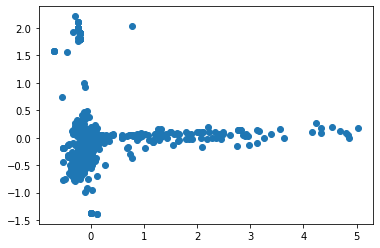

In [37]:
fig = plt.figure()
plt.plot(vectors2d[:,0], vectors2d[:,1],'o')

### 3.2 Train

Now we create our model with 20\*20 neurons and train it

In [38]:
mapsize = [20, 20]  # The number of neurons: 20*20
som = sompy3.SOMFactory.build(vectors2d, mapsize, normalization=None)
som.train(n_job=1, verbose='info') 

INFO:root: Training...
INFO:root: pca_linear_initialization took: 0.009000 seconds
INFO:root: Rough training...
INFO:root: radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 6

INFO:root: epoch: 1 ---> elapsed time:  0.120000, quantization error: 0.201692

INFO:root: epoch: 2 ---> elapsed time:  0.115000, quantization error: 0.059123

INFO:root: epoch: 3 ---> elapsed time:  0.115000, quantization error: 0.037678

INFO:root: epoch: 4 ---> elapsed time:  0.117000, quantization error: 0.032208

INFO:root: epoch: 5 ---> elapsed time:  0.132000, quantization error: 0.027746

INFO:root: epoch: 6 ---> elapsed time:  0.118000, quantization error: 0.023556

INFO:root: Finetune training...
INFO:root: radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 7

INFO:root: epoch: 1 ---> elapsed time:  0.119000, quantization error: 0.018543

INFO:root: epoch: 2 ---> elapsed time:  0.120000, quantization error: 0.017719

INFO:root: epoch: 3 ---> elapsed time:  0.113000, quantization error: 0.01

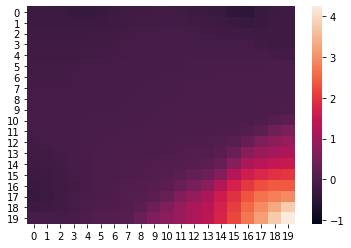

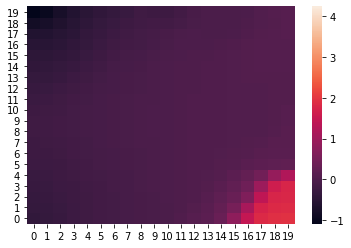

In [41]:
c1, c2 = som.codebook.matrix[:, 0].reshape(mapsize), som.codebook.matrix[:, 1].reshape(mapsize)  # We select the two components (dimensions) in the map, and reshape them
# Two heatmaps, one per component
sns.heatmap(c1, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
plt.ylim(0, 20)
plt.show()
sns.heatmap(c2, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
plt.ylim(0, 20)
plt.show()

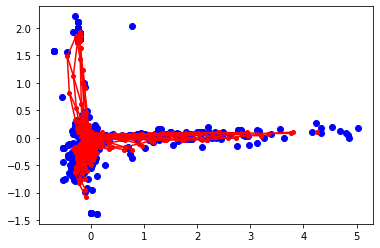

In [31]:
plt.plot(vectors2d[:,0], vectors2d[:,1],'o', c="b")
plt.plot(som.codebook.matrix[:, 0], som.codebook.matrix[:, 1], "o", c="r", markersize=4)
for i in range(c1.shape[0]-1):
    for j in range(c2.shape[1]-1):
        plt.plot(c1[i, j:j+2], c2[i, j:j+2], c="r")
        plt.plot(c1[i:i+2, j], c2[i:i+2, j], c="r")

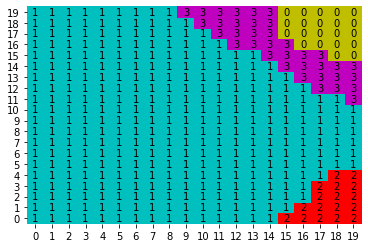

In [32]:
cl = som.cluster(n_clusters=4)

cmap = ["y", "c", "r", "m"]
cluster_space = som.cluster_labels.reshape(mapsize)
sns.heatmap(cluster_space, annot=True, cmap=cmap, annot_kws={"c": "k"}, cbar=False)
plt.ylim(0, 20)
plt.show()

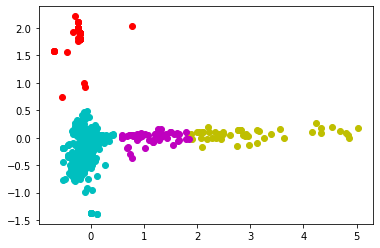

In [43]:
projected_data = som.project_data(vectors2d)
clusters = cl[projected_data]

for i in range(vectors2d.shape[0]):
    plt.plot(vectors2d[i,0], vectors2d[i,1],'o', c=cmap[clusters[i]])

In [45]:
def UMat(c1, c2):
    dists = np.zeros(c1.shape)
    for i in range(c1.shape[0]):
        for j in range(c2.shape[1]):
            cnt = 0
            if i > 0:
                dists[i, j] += np.sqrt((c1[i-1, j] - c1[i, j])**2 + (c2[i-1, j] - c2[i, j])**2)
                cnt += 1
            if j > 0:
                dists[i, j] += np.sqrt((c1[i, j-1] - c1[i, j])**2 + (c2[i, j-1] - c2[i, j])**2)
                cnt += 1
            if j < c2.shape[1]-1:
                dists[i, j] += np.sqrt((c1[i, j+1] - c1[i, j])**2 + (c2[i, j+1] - c2[i, j])**2)
                cnt += 1
            if i < c2.shape[1]-1:
                dists[i, j] += np.sqrt((c1[i+1, j] - c1[i, j])**2 + (c2[i+1, j] - c2[i, j])**2)
                cnt += 1
            dists[i, j] /= cnt
    return dists

<AxesSubplot:>

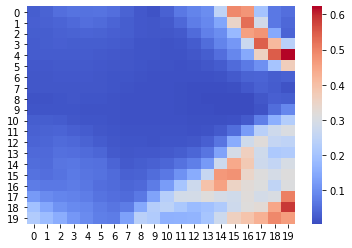

In [46]:
umat = UMat(c1, c2)
sns.heatmap(umat, cmap='coolwarm')

### 3.3 Visualization

## 4. Discuss the results